In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
import janitor 
from obspy.signal.trigger import classic_sta_lta
from scipy import signal, ndimage

from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

from scipy.fft import fft, ifft, fftfreq

from scipy import signal
from scipy.signal import find_peaks


In [79]:
class SismicDataset(Dataset):
    def __init__(self, max_length=572427):
        # Cargar el catálogo CSV
        self.cat = pd.read_csv('./data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv')
        self.data_directory = './data/lunar/training/data/S12_GradeA'
        self.max_length = max_length  # Define la longitud máxima de las secuencias

    def __len__(self):
        return len(self.cat)

    def __getitem__(self, idx):
        # Obtener los datos de la fila correspondiente
        row = self.cat.iloc[idx]
        test_filename = row['filename']
        arrival_time_rel = row['time_rel(sec)']
        arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')

        # Construir la ruta al archivo .mseed
        mseed_file = os.path.join(self.data_directory, f'{test_filename}.mseed')

        # Leer los datos de la señal usando obspy
        minfreq = 0.1
        maxfreq = 3.0

        st = read(mseed_file)
        st_filt = st.copy()
        st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
        tr_filt = st_filt.traces[0].copy()
        tr_times_filt = tr_filt.times()
        tr_data_filt = tr_filt.data
        df = tr_filt.stats.sampling_rate
        f, t, sxx = signal.spectrogram(tr_data_filt, df, nperseg=2000, noverlap=1800)


        # This is how you get the data and the time, which is in seconds
        tr = st.traces[0].copy()
        tr_times = tr.times()
        tr_data = tr.data

        # Start time of trace (another way to get the relative arrival time using datetime)
        starttime = tr.stats.starttime.datetime
        arrival = (arrival_time - starttime).total_seconds()


        diff = np.abs(t - arrival)
        index = np.argmin(diff)
        # Convertir los datos a tensores
        
        return tr_data_filt, tr_times_filt, f, t, sxx, arrival, index, df 

47
10
[16899]
17487


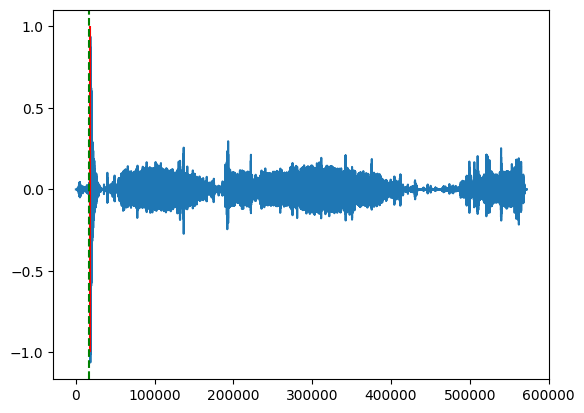

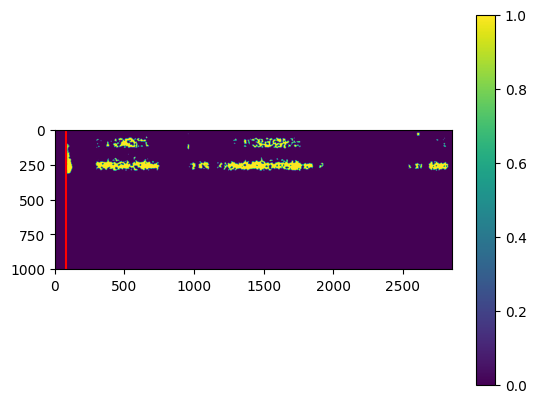

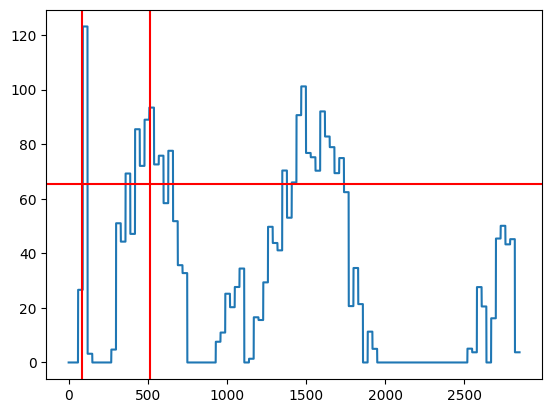

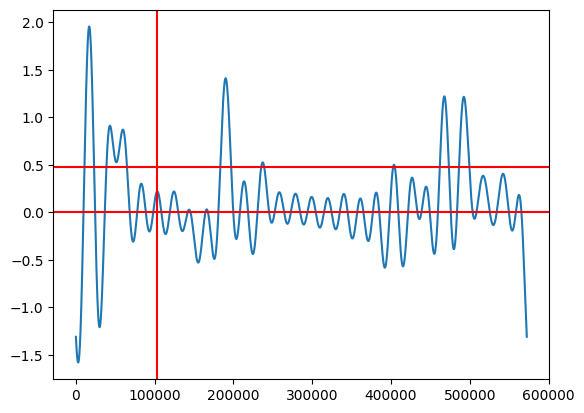

47
[ 16899  59652 103346 190075 237149 278798 340162 403832 467743 542265]
[  84.13851838  297.0016509   514.54993318  946.36539923 1180.74238096
 1388.10880218 1693.63433872 2010.64123058 2328.84803857 2699.88600928]
[[16899]]
[17487]


In [99]:
data = SismicDataset()
#ix = np.arange(0, 76, 1)
ix = np.array([47])
index_arrival_predicted = []
index_arrival_real = []
for ix in ix:

    print(ix)

    tr_data_filt, tr_times_filt, f, t, sxx, arrival, index, df = data.__getitem__(ix)

    filter1 = sxx > np.mean(sxx)
    filter1 = filter1.astype(int)

    kernel = np.ones((5, 5))
    conv = ndimage.convolve(filter1, kernel, mode='reflect')
    for j in range(8):
        conv = ndimage.convolve(conv, kernel, mode='reflect')

    filter2 = conv > np.quantile(conv, q=0.97)
    filter2 = filter2.astype(int)

    # 1. Sumar los valores de cada columna
    col_sums = np.sum(filter2, axis=0)  # Suma de cada columna

    # Verificar que el arreglo sea divisible por 20. Si no lo es, puedes recortar o añadir valores.
    if len(col_sums) % 30 != 0:
        col_sums = col_sums[:-(len(col_sums) % 30)]  # Recorta los elementos restantes que no completen un conjunto de 30

    # Dividir el arreglo en grupos de 30 y calcular el promedio de cada grupo
    promedios = np.mean(col_sums.reshape(-1, 30), axis=1)

    # Crear un nuevo arreglo donde cada grupo de 30 valores es reemplazado por su promedio
    col_sums = np.repeat(promedios, 30)  # Repite cada promedio 30 veces para generar el nuevo arreglo

    ### NORMALIZATIOONN

    # Normalize [-1, 1]
    # Reshape array to use MinMaxScaler
    tr_data_filt_norm = tr_data_filt.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    tr_data_filt_norm = scaler.fit_transform(tr_data_filt_norm)

    tr_data_filt_norm = tr_data_filt_norm - np.mean(tr_data_filt_norm) ##CENTRAR LA SEÑAL


    ### CFT

    # Sampling frequency of our trace
    #df = tr.stats.sampling_rate

    # How long should the short-term and long-term window be, in seconds?\
    sta_len = 60
    lta_len = 900
    # sta_len = 1000
    # lta_len = 2000

    # Run Obspy's STA/LTA to obtain a characteristic function
    # This function basically calculates the ratio of amplitude between the short-term 
    # and long-term windows, moving consecutively in time across the data
    #cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))
    tr_data_filt_norm = tr_data_filt_norm.reshape(-1)
    cft = classic_sta_lta(tr_data_filt_norm, int(sta_len * df), int(lta_len * df))
    
    diff = np.abs(tr_times_filt - arrival)
    index_arrival = np.argmin(diff)

    ### FFT

    # Número de puntos en el arreglo
    n = len(cft)

    # Frecuencia de muestreo (puedes ajustarla dependiendo del contexto)
    sampling_rate = 1.0  # Ajusta según corresponda

    # Realizar la FFT del arreglo
    cft_fft = fft(cft)

    # Crear las frecuencias correspondientes
    frequencies = fftfreq(n, d=sampling_rate)

    # Definir la frecuencia de corte para el filtro
    cutoff_freq = 0.0001/2 # Ajusta según lo que necesites

    # Aplicar el filtro pasa bajos: eliminar las frecuencias más altas que la frecuencia de corte
    cft_fft[np.abs(frequencies) > cutoff_freq] = 0

    # Realizar la inversa de la FFT para regresar al dominio temporal
    filtered_cft = ifft(cft_fft)

    # La señal filtrada está en dominio temporal (real)
    filtered_cft_real = np.real(filtered_cft)
    filtered_cft_real = filtered_cft_real - 1

    ### HALLAR PICOS

    picos, _ = find_peaks(filtered_cft_real, height = np.std(filtered_cft_real)/4, distance = 40000)
    
    ind_s = picos*(np.shape(col_sums)[0]/np.shape(filtered_cft_real)[0])

    predictions = []
    
    for i in range(len(ind_s)):
        #a = np.where(col_sums > 2*np.std(col_sums))
        a = np.where(col_sums > 120)

        indices_a_verificar = np.arange(int(ind_s[i]), int(ind_s[i]) + 100, 1)

        # Verificar si estos índices están en la lista de indices_mayores usando np.isin()
        #result = np.isin(indices_a_verificar, a).all()
        result = np.isin(indices_a_verificar, a).any()

        if result:
            #print("TRUE")
            predictions.append(picos[i])

    index_arrival_predicted.append(predictions)
    index_arrival_real.append(index_arrival)

    print(len(ind_s))
    print(predictions)
    print(index_arrival)

    plt.plot(tr_data_filt_norm)
    plt.vlines(index_arrival,-1,1,color="red")
    for pos in predictions:
        plt.axvline(x=pos, color='green', linestyle='--', label=f'Vertical en x={pos}')
    plt.show()

    plt.imshow(filter2)
    plt.colorbar()
    plt.axvline(x=index, color='red')
    plt.show()

    plt.plot(col_sums)
    plt.axvline(x=index, color='red')
    plt.axvline(x=ind_s[2], color='red')
    plt.axhline(y=2*np.std(col_sums), color='red')
    plt.show()

    plt.plot(filtered_cft_real)
    plt.axhline(y=np.std(filtered_cft_real), color='red')
    plt.axvline(x=picos[2], color='red')
    plt.axhline(y=0, color='red')
    plt.show()


    print(ix)
    print(picos)
    print(ind_s)
print(index_arrival_predicted)
print(index_arrival_real)
    



(400000.0, 500000.0)

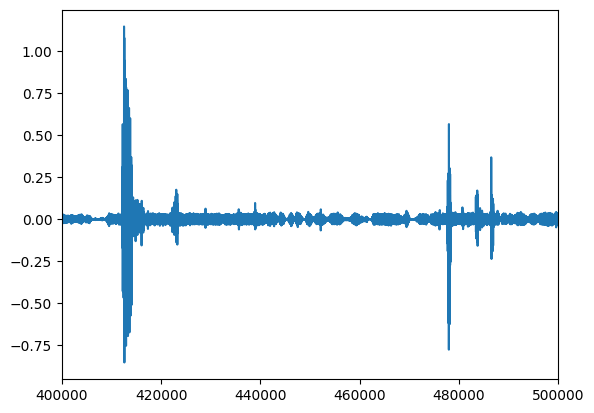

In [94]:
plt.plot(tr_data_filt_norm)
plt.xlim((400000, 500000))

0


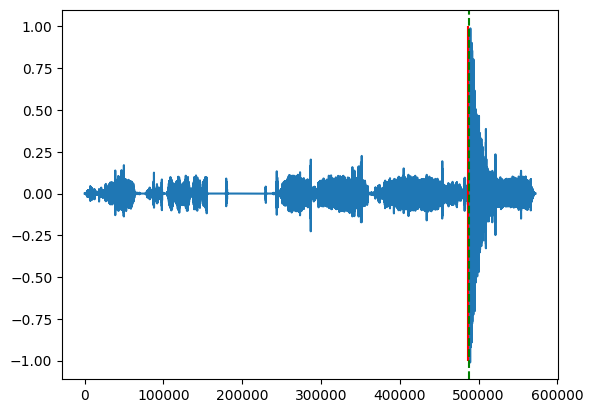

1


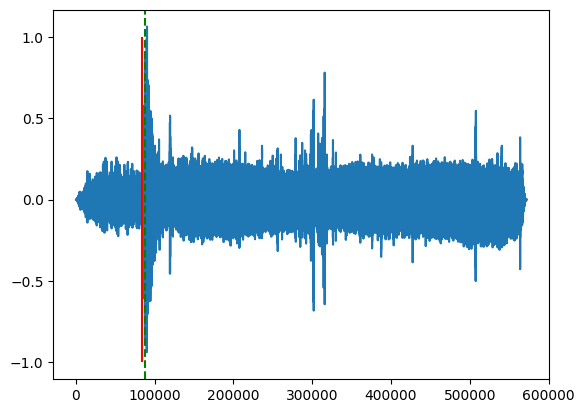

2


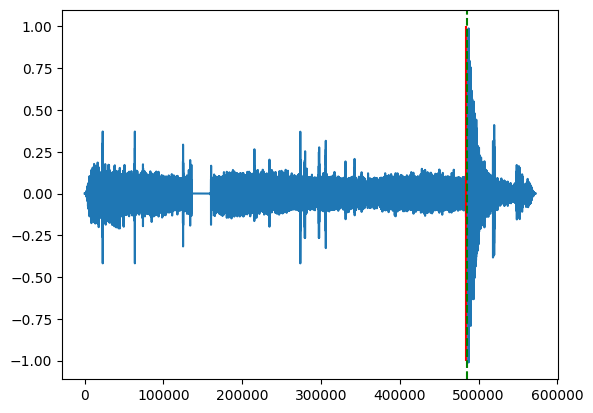

3


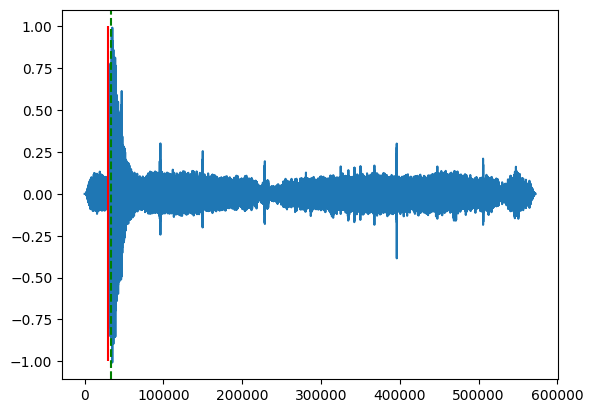

4


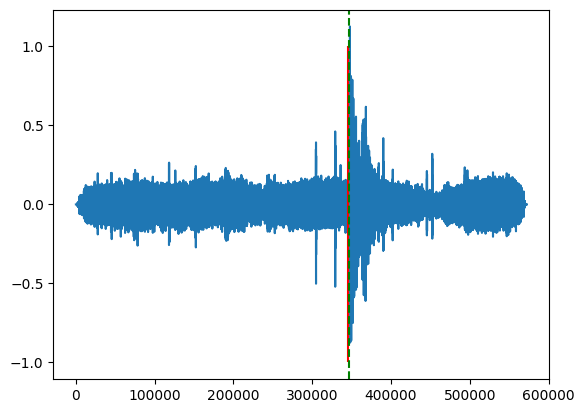

5


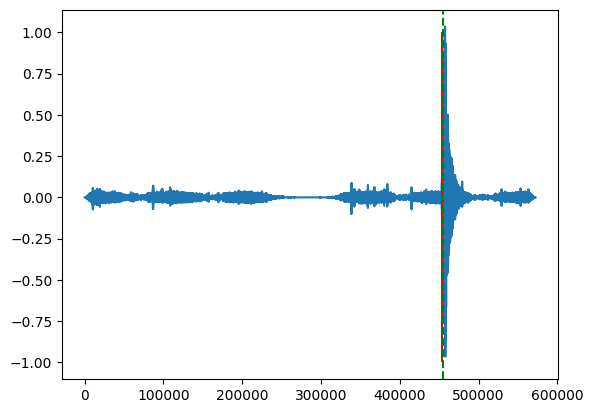

6


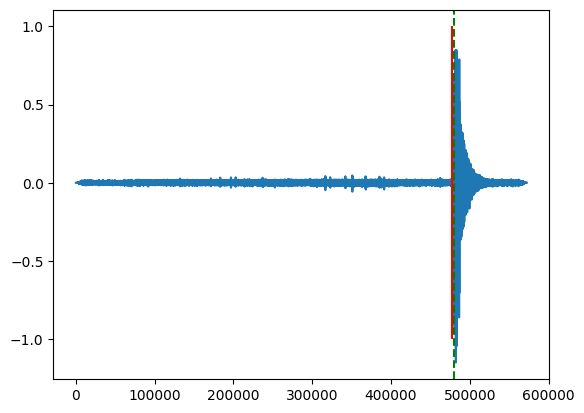

7


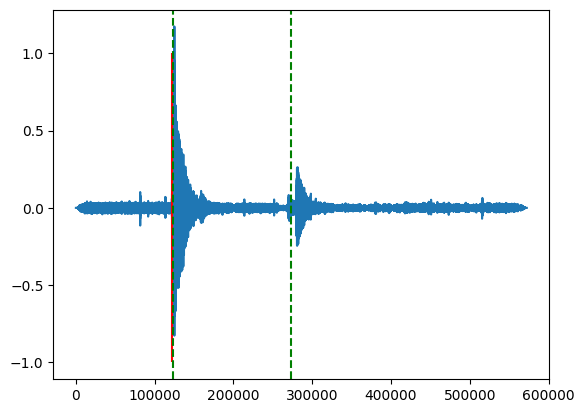

8


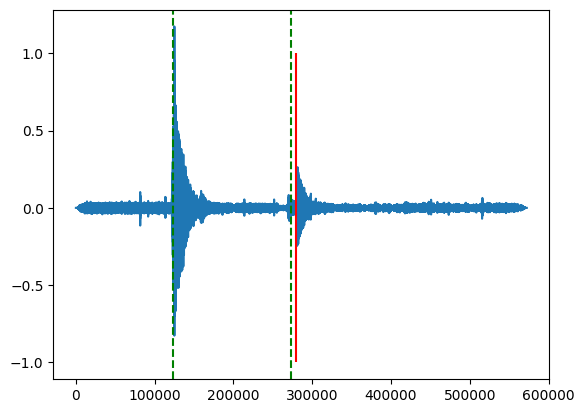

9


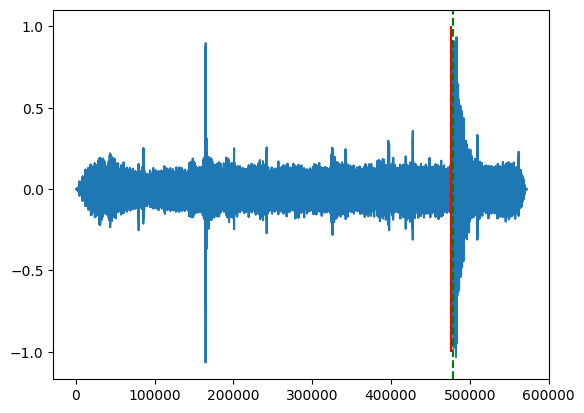

10


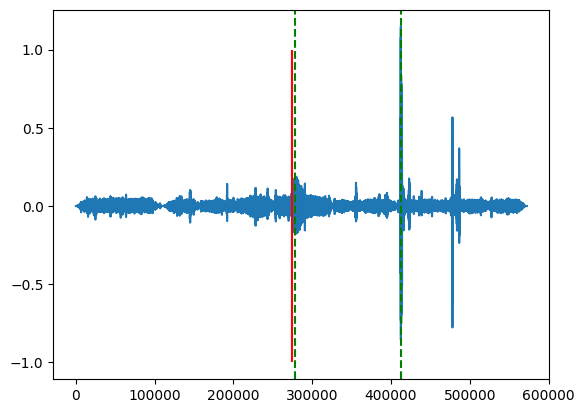

11


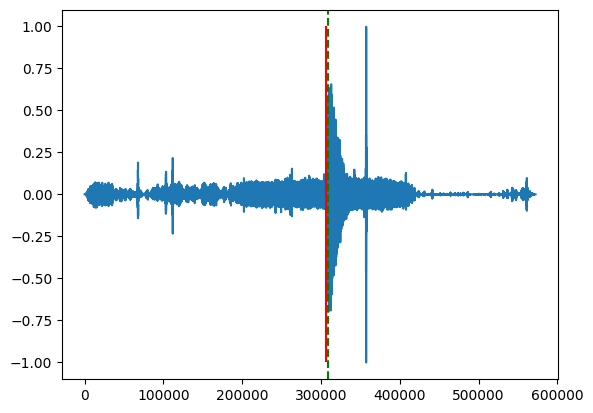

12


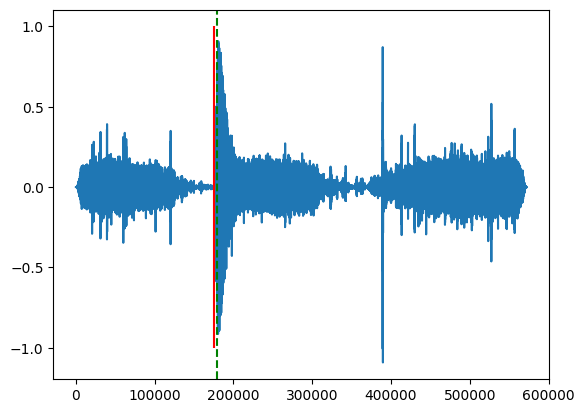

13


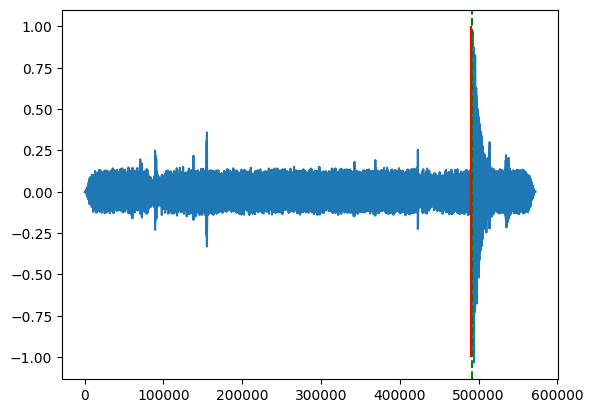

14


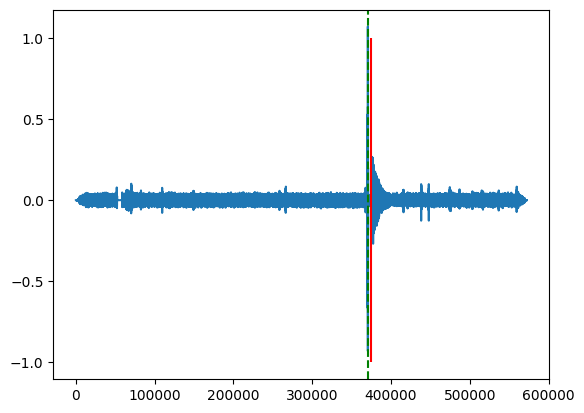

15


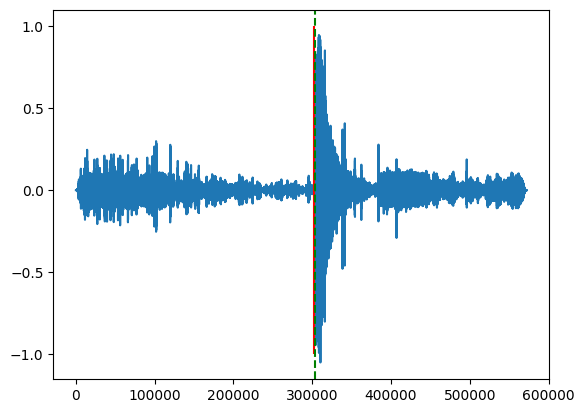

16


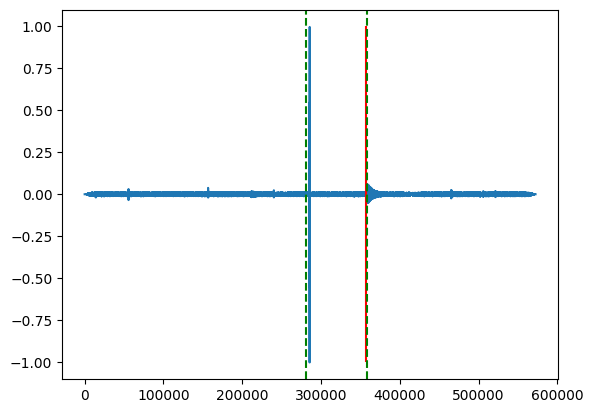

17


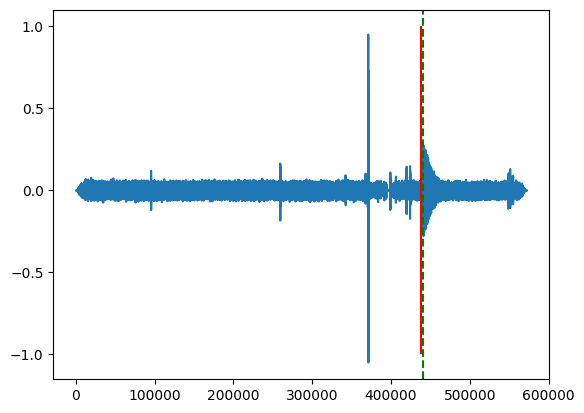

18


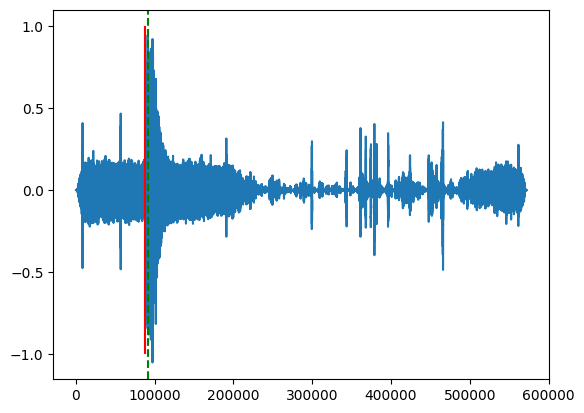

19


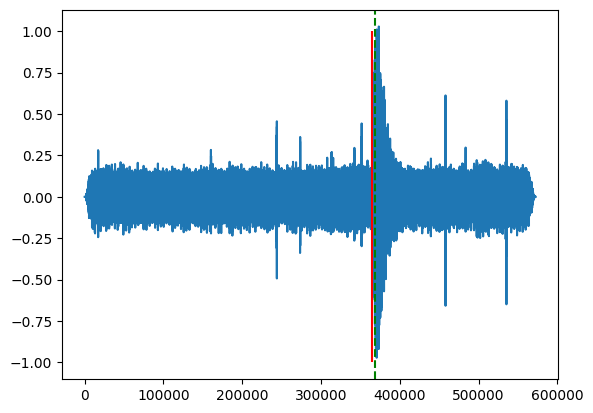

20


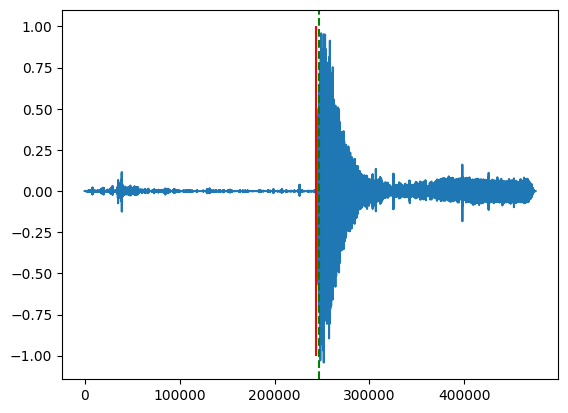

21


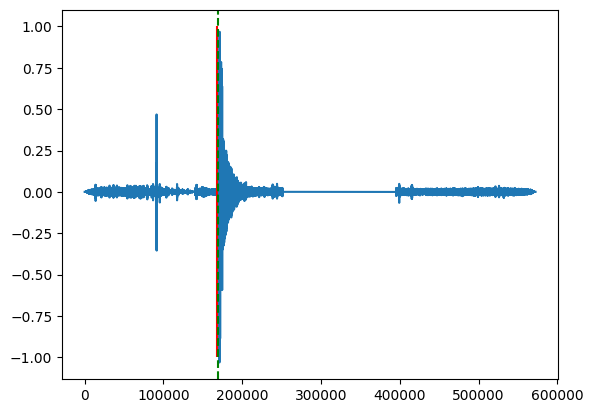

22


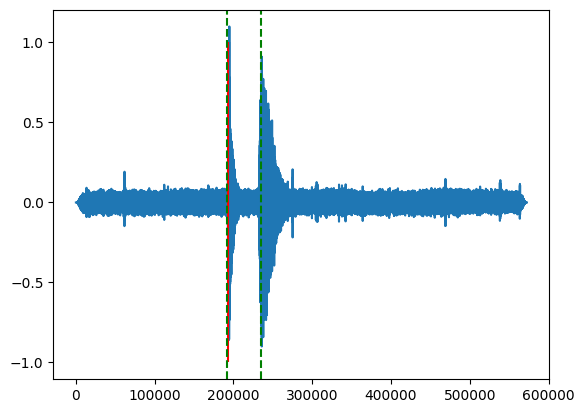

23


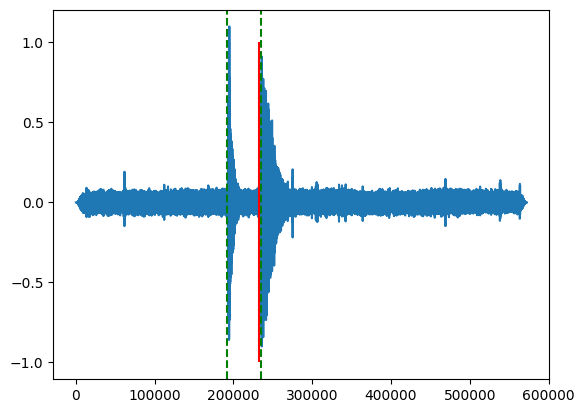

24


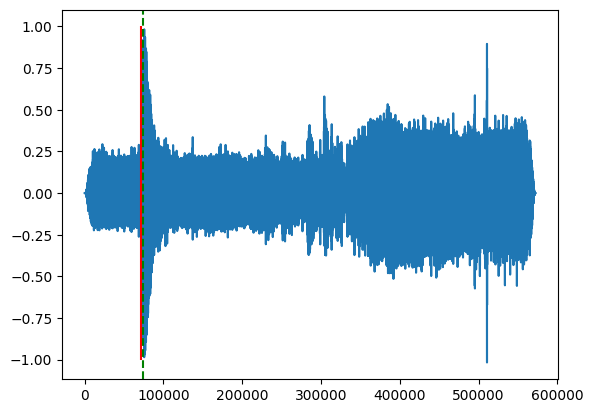

25


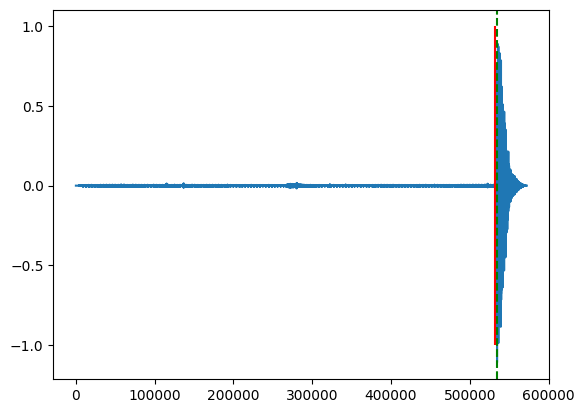

26


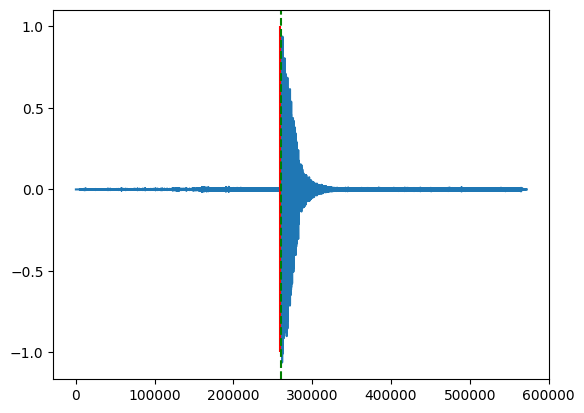

27


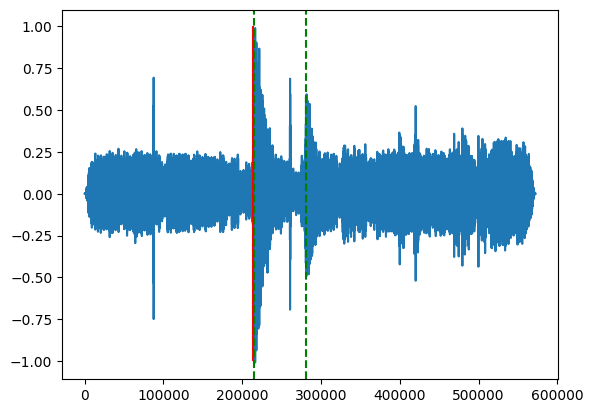

28


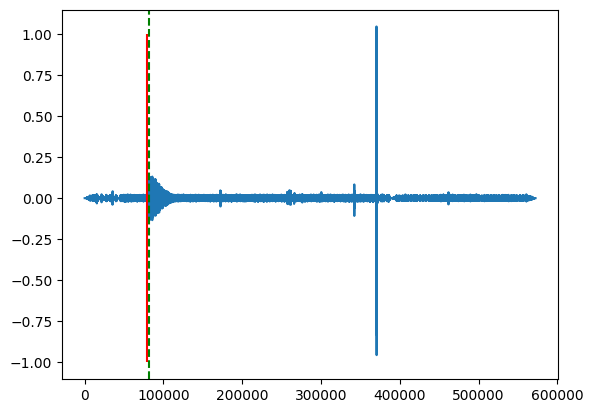

29


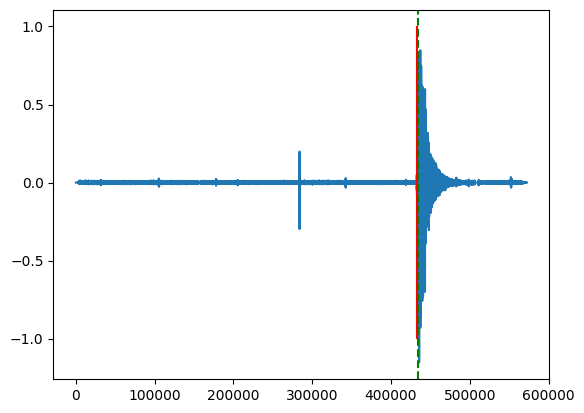

30


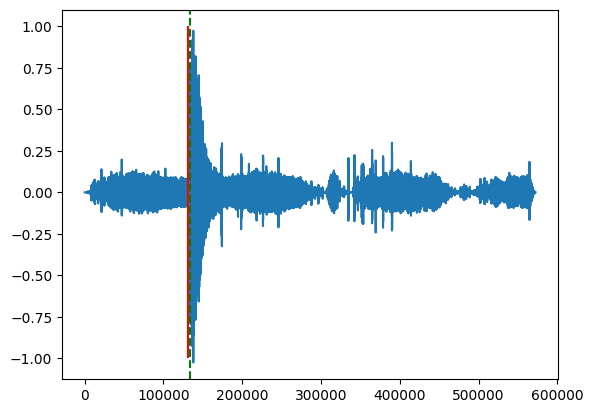

31


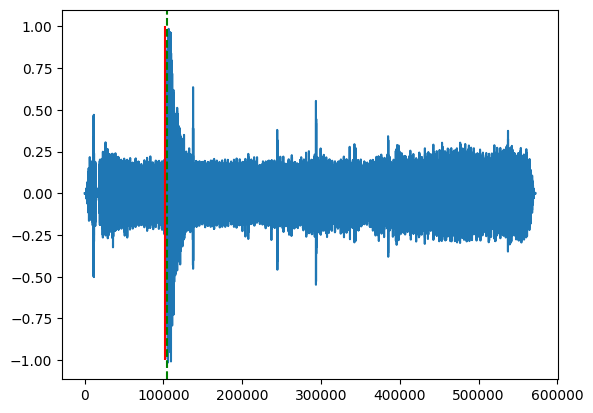

32


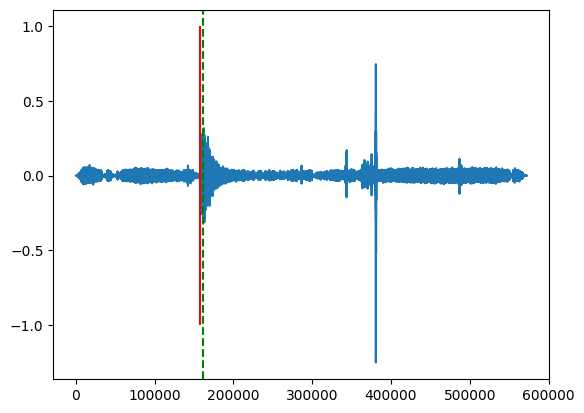

33


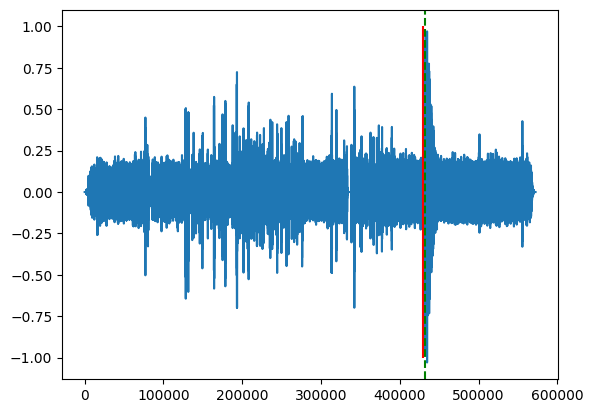

34


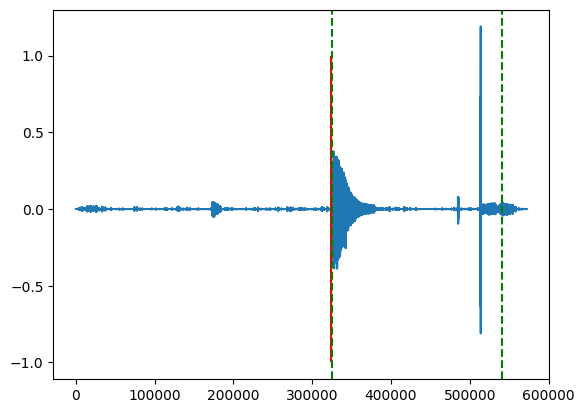

35


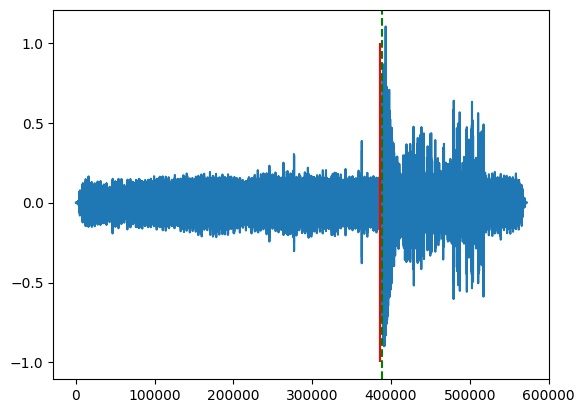

36


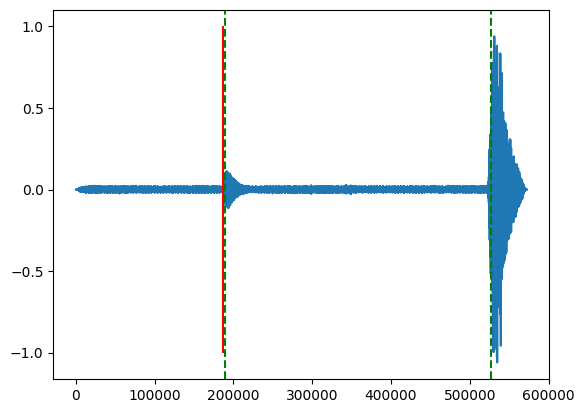

37


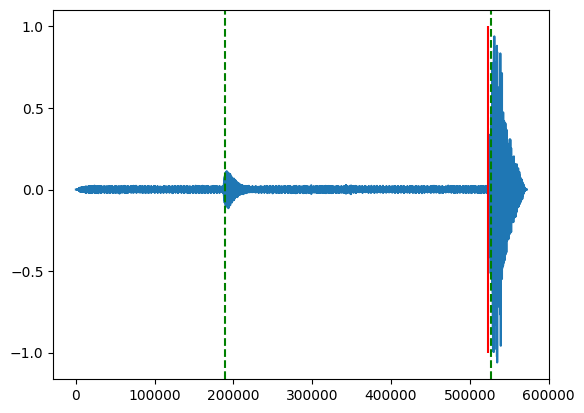

38


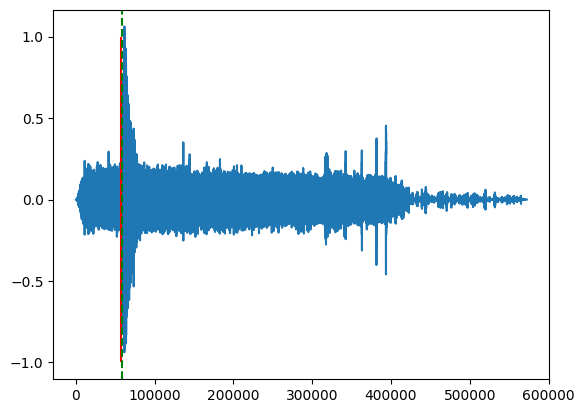

39


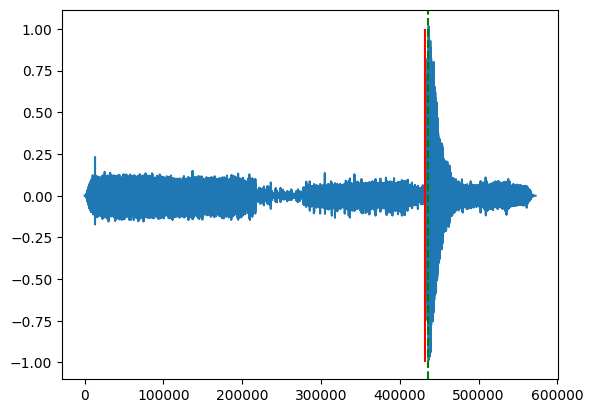

40


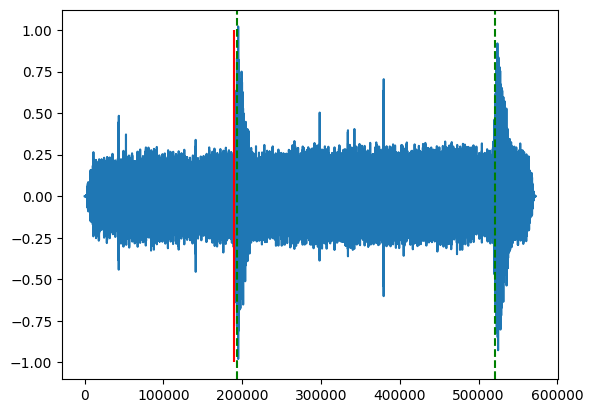

41


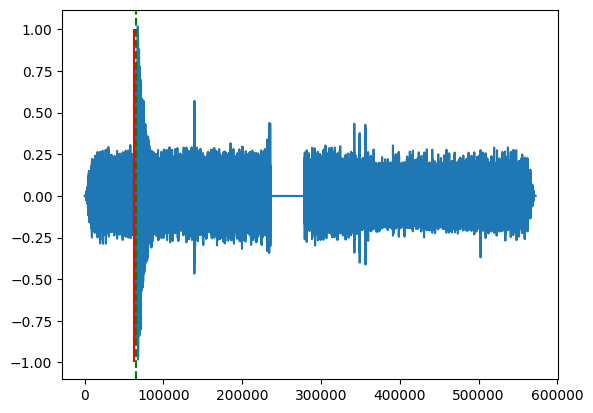

42


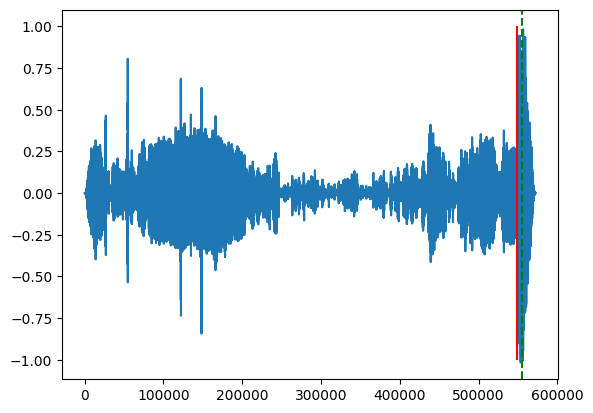

43


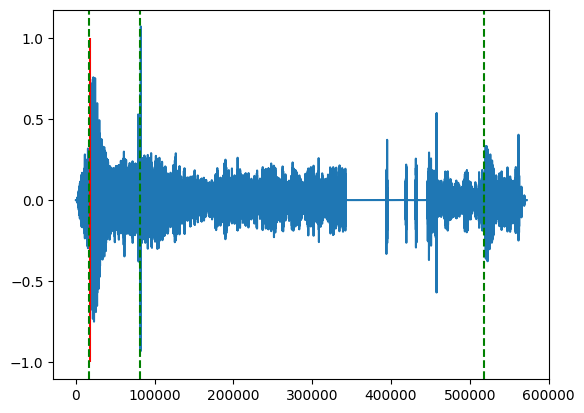

44


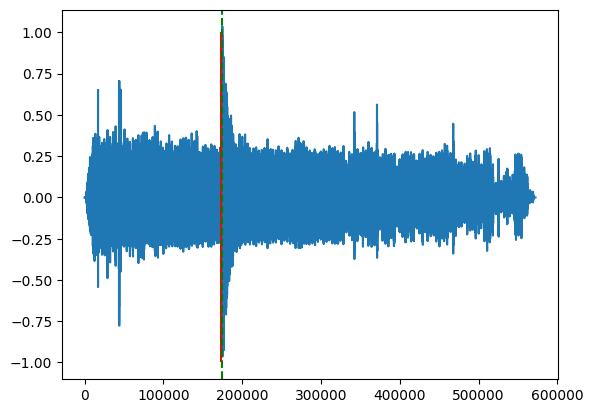

45


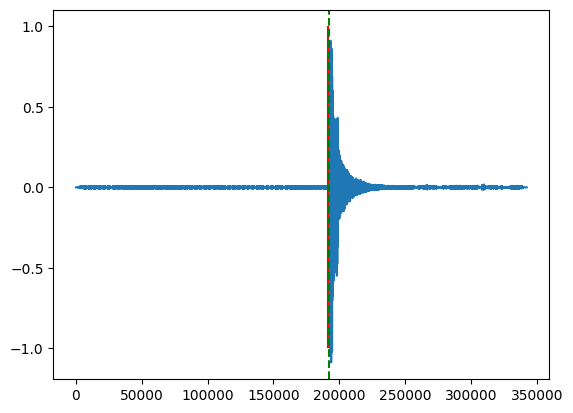

46


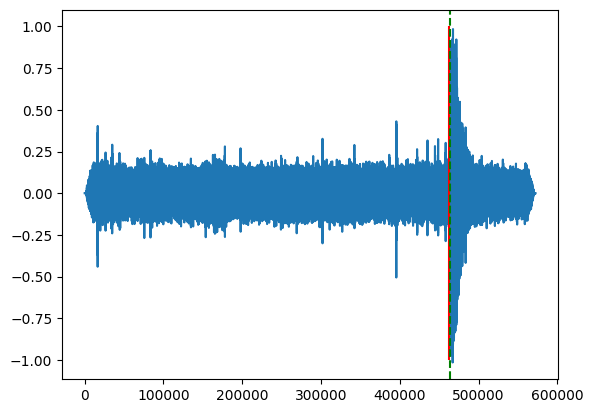

47


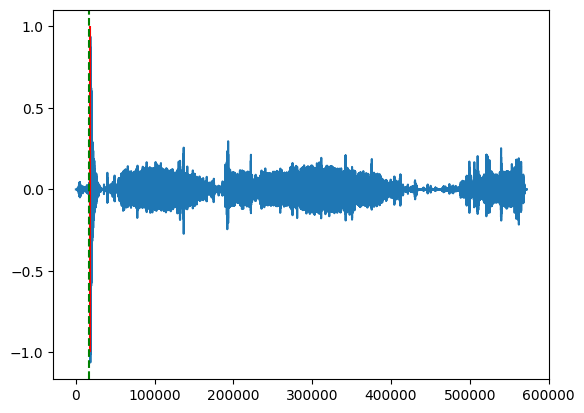

48


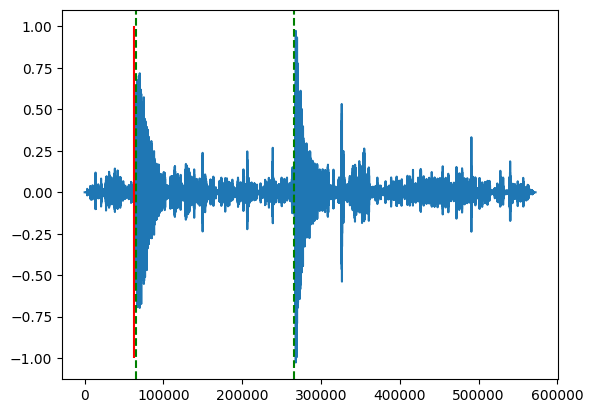

49


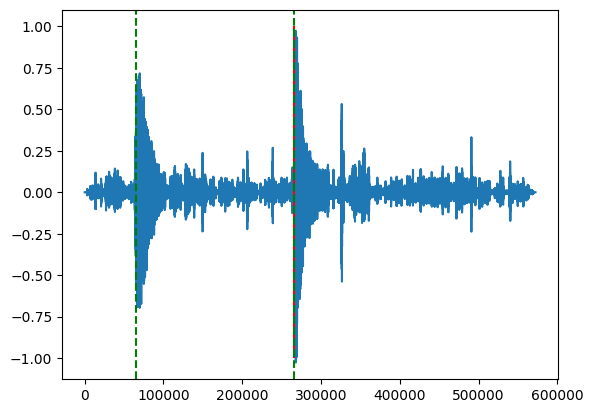

50


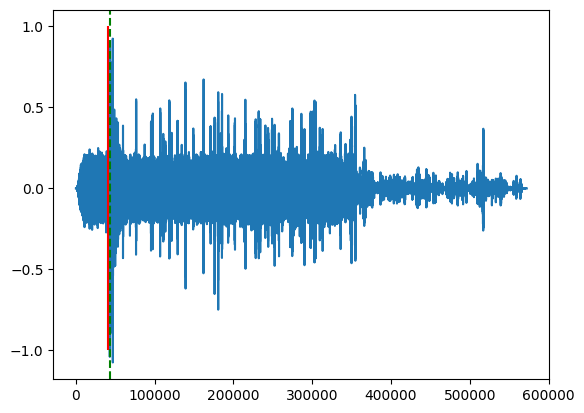

51


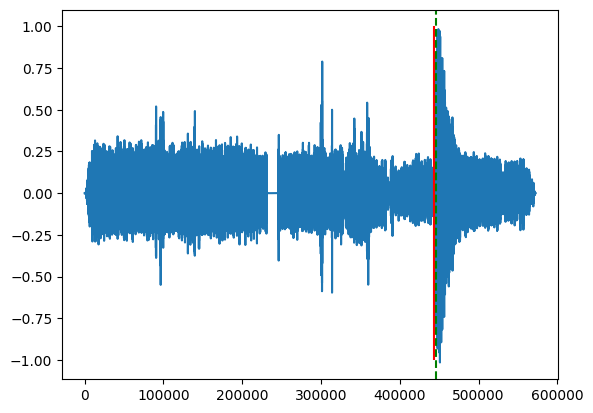

52


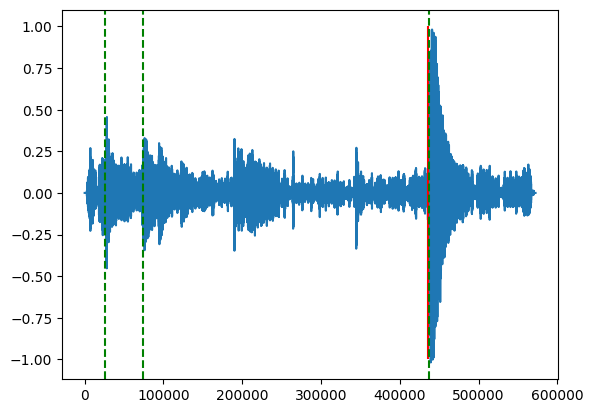

53


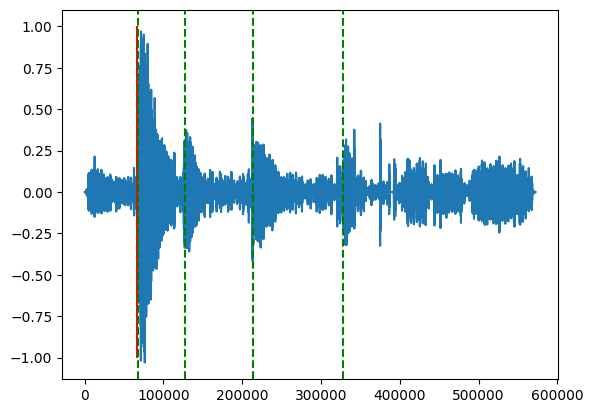

54


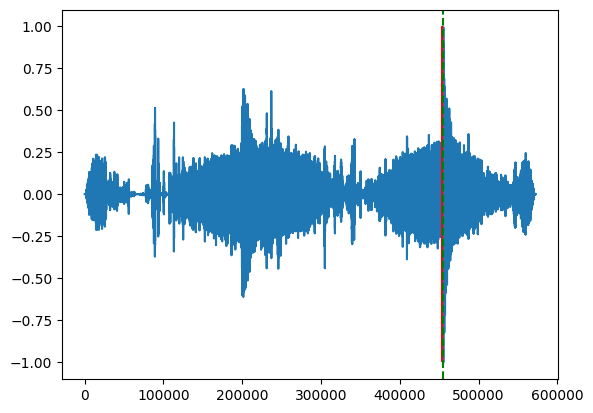

55


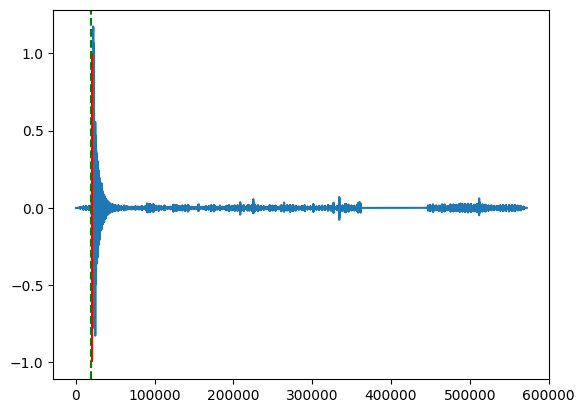

56


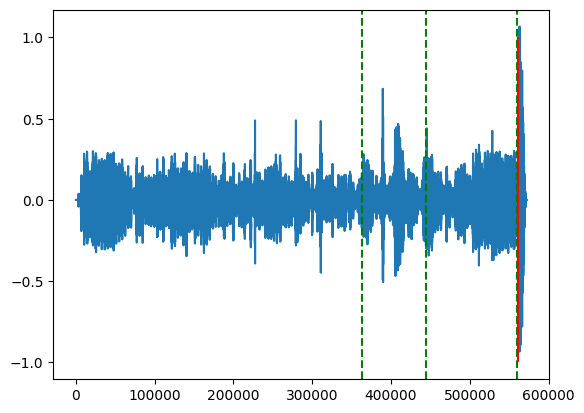

57


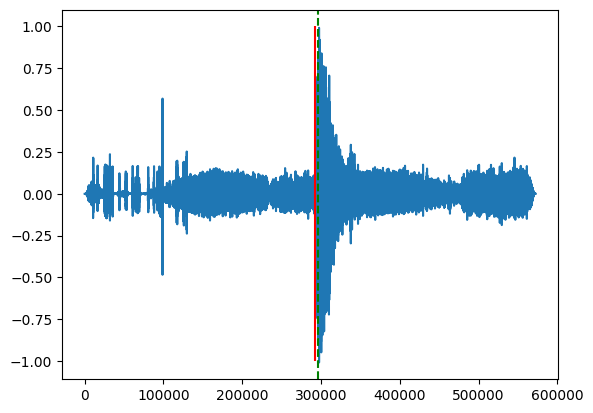

58


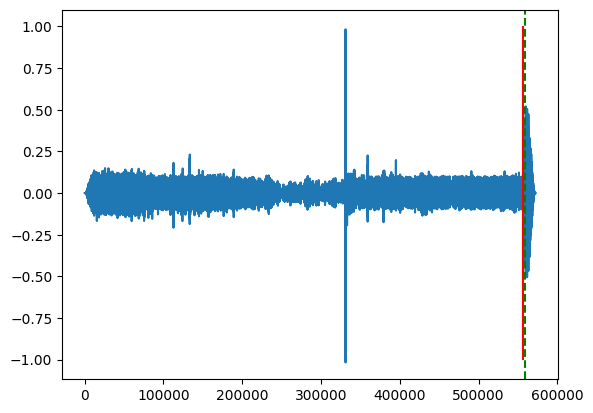

59


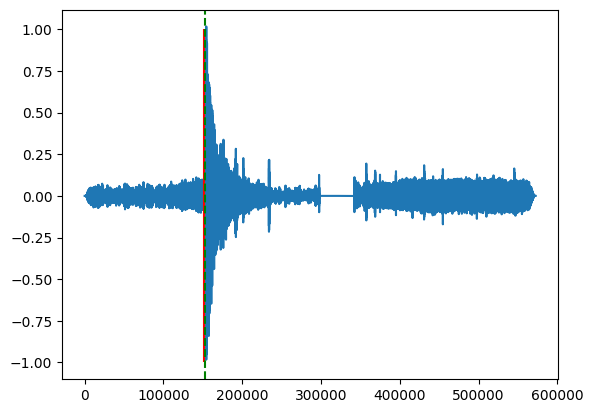

60


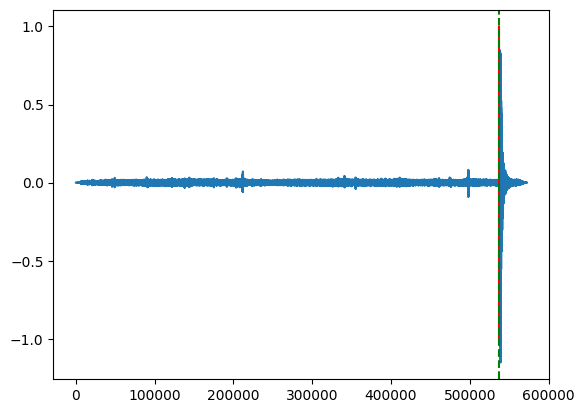

61


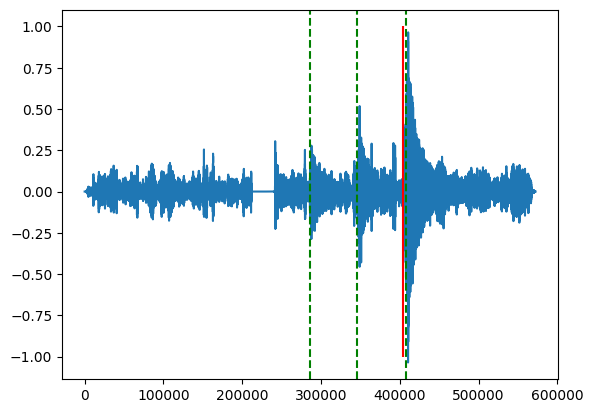

62


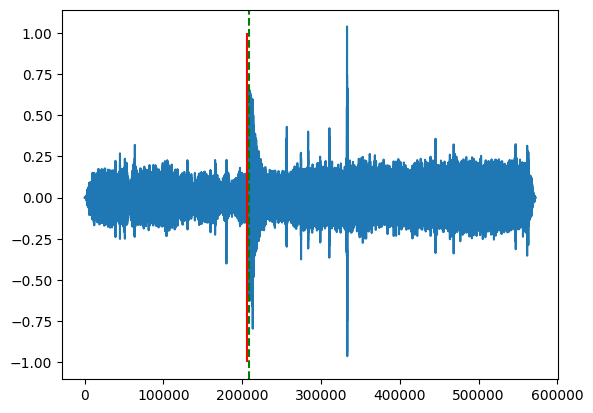

63


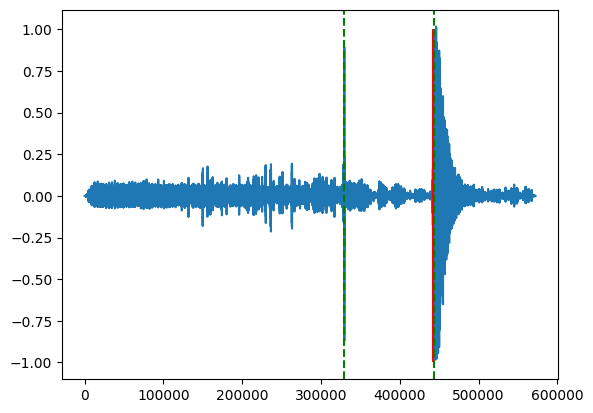

64


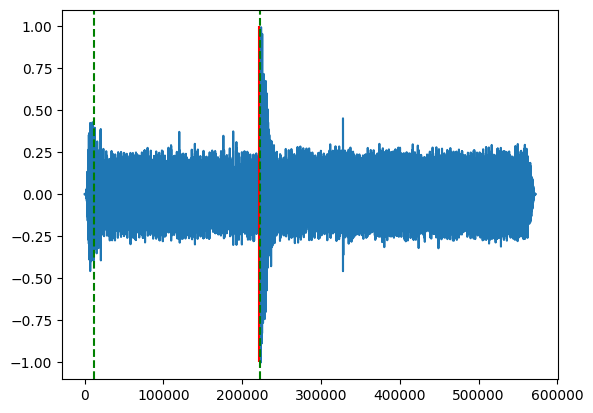

65


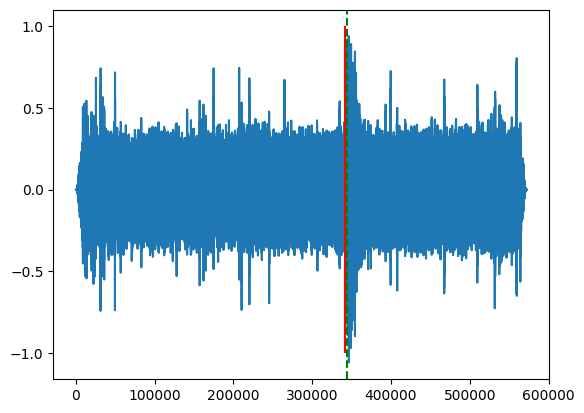

66


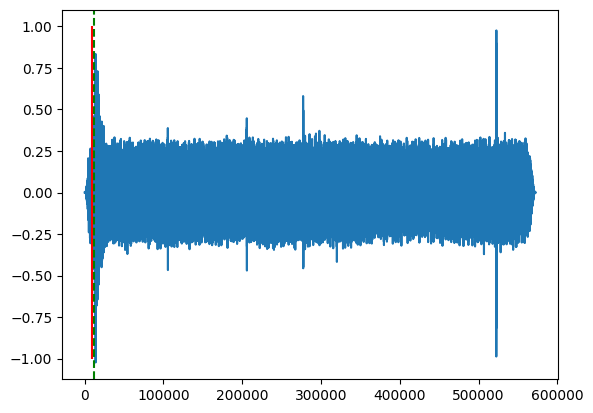

67


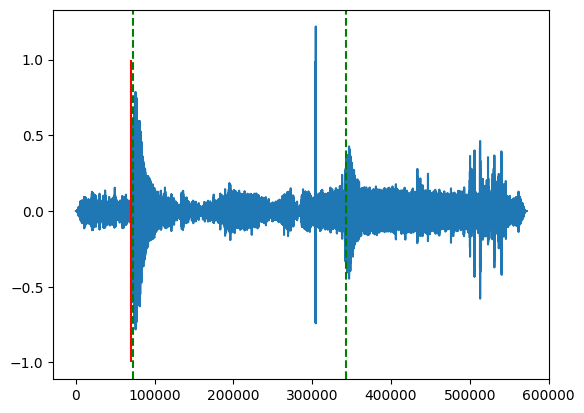

68


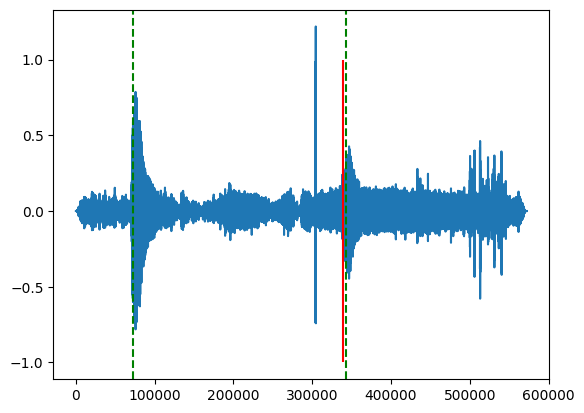

69


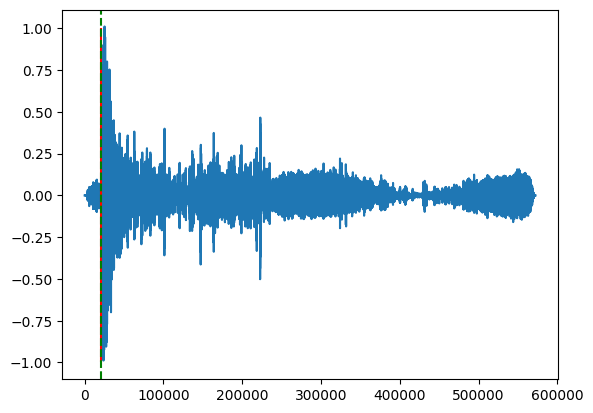

70


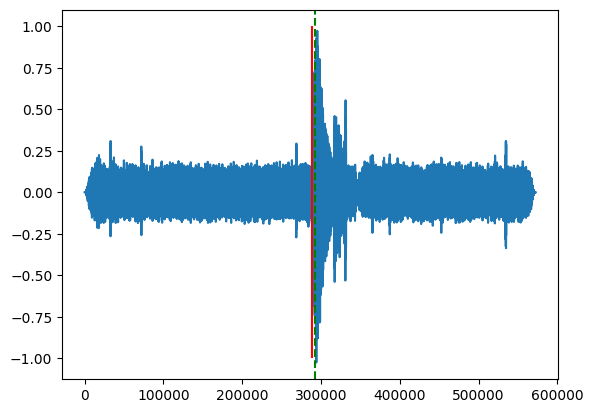

71


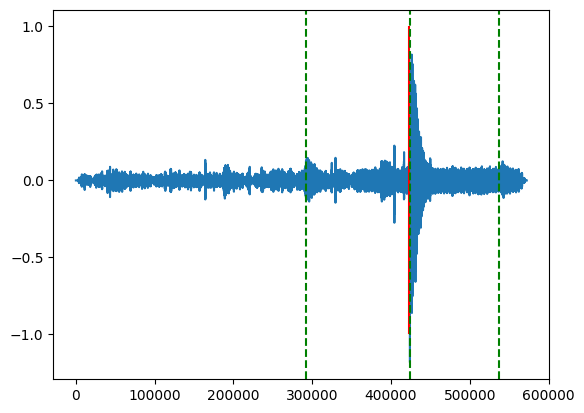

72


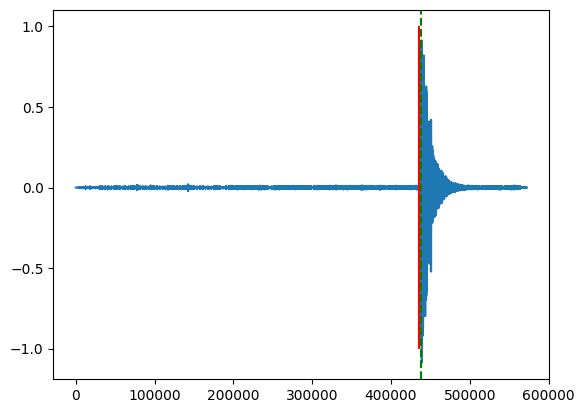

73


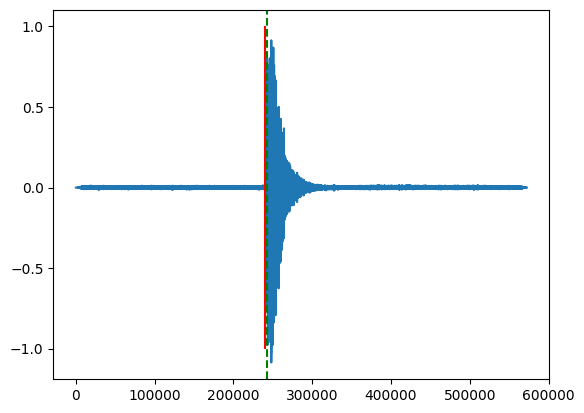

74


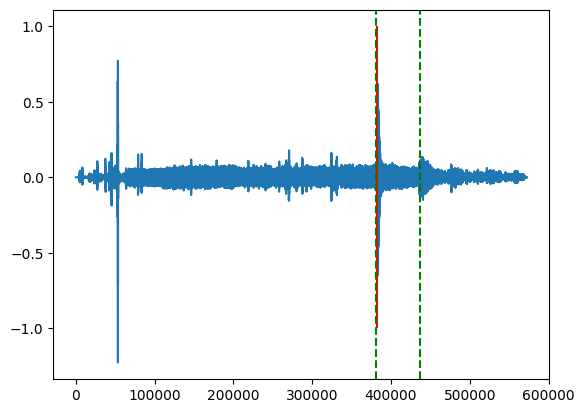

75


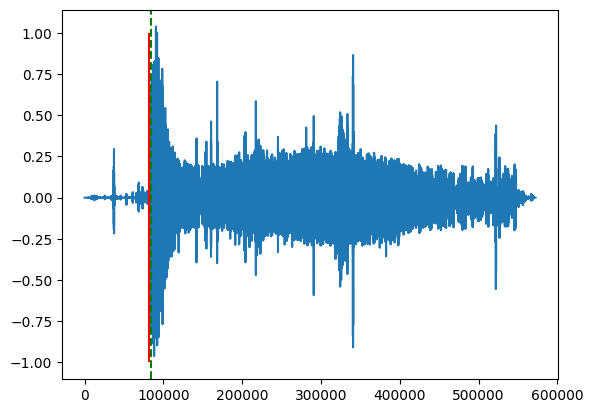

In [90]:
data = SismicDataset()
ix = np.arange(0, 76, 1)
#ix = np.array([24])
for ix in ix:

    print(ix)

    tr_data_filt, tr_times_filt, f, t, sxx, arrival, index, df = data.__getitem__(ix)
   
    filter1 = sxx > np.mean(sxx)
    filter1 = filter1.astype(int)

    kernel = np.ones((5, 5))
    conv = ndimage.convolve(filter1, kernel, mode='reflect')
    for j in range(8):
        conv = ndimage.convolve(conv, kernel, mode='reflect')

    filter2 = conv > np.quantile(conv, q=0.97)
    filter2 = filter2.astype(int)

    # 1. Sumar los valores de cada columna
    col_sums = np.sum(filter2, axis=0)  # Suma de cada columna

    # Verificar que el arreglo sea divisible por 20. Si no lo es, puedes recortar o añadir valores.
    if len(col_sums) % 50 != 0:
        col_sums = col_sums[:-(len(col_sums) % 50)]  # Recorta los elementos restantes que no completen un conjunto de 50

    # Dividir el arreglo en grupos de 50 y calcular el promedio de cada grupo
    promedios = np.mean(col_sums.reshape(-1, 50), axis=1)

    # Crear un nuevo arreglo donde cada grupo de 50 valores es reemplazado por su promedio
    col_sums = np.repeat(promedios, 50)  # Repite cada promedio 50 veces para generar el nuevo arreglo

    ### NORMALIZATIOONN

    # Normalize [-1, 1]
    # Reshape array to use MinMaxScaler
    tr_data_filt_norm = tr_data_filt.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    tr_data_filt_norm = scaler.fit_transform(tr_data_filt_norm)

    tr_data_filt_norm = tr_data_filt_norm - np.mean(tr_data_filt_norm) ##CENTRAR LA SEÑAL


    # diff = np.abs(tr_times_filt - arrival)
    # index_arrival = np.argmin(diff)

    # print(len(ind_s))
    # print(predictions)
    # print(index_arrival)

    plt.plot(tr_data_filt_norm)
    plt.vlines(index_arrival_real[ix],-1,1,color="red")
    for pos in index_arrival_predicted[ix]:
        plt.axvline(x=pos, color='green', linestyle='--')
    plt.show()

    # plt.imshow(filter2)
    # plt.colorbar()
    # #plt.axvline(x=index, color='red')
    # plt.show()

    # plt.plot(col_sums)
    # #plt.colorbar()
    # #plt.axvline(x=index, color='red')
    # #plt.axvline(x=ind_s[2], color='red')
    # plt.axhline(y=2*np.std(col_sums), color='red')
    # plt.show()

    # plt.plot(filtered_cft_real)
    # # #plt.colorbar()
    # # plt.axhline(y=np.std(filtered_cft_real), color='red')
    # plt.show()


    # print(ix)
    # print(picos)
    # print(ind_s)

/tmp/ipykernel_18499/1465134648.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


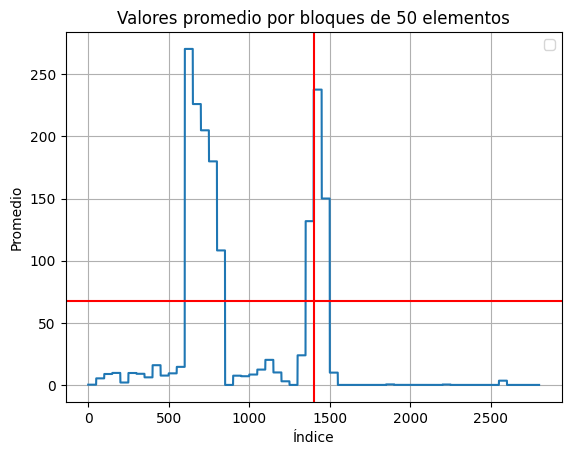

TRUE
TRUE
2
[125296, 281756]
279837


In [192]:
# Verificar que el arreglo sea divisible por 20. Si no lo es, puedes recortar o añadir valores.
if len(col_sums) % 50 != 0:
    col_sums = col_sums[:-(len(col_sums) % 50)]  # Recorta los elementos restantes que no completen un conjunto de 50

# Dividir el arreglo en grupos de 50 y calcular el promedio de cada grupo
promedios = np.mean(col_sums.reshape(-1, 50), axis=1)

# Crear un nuevo arreglo donde cada grupo de 50 valores es reemplazado por su promedio
nuevo_arreglo = np.repeat(promedios, 50)  # Repite cada promedio 50 veces para generar el nuevo arreglo

# Graficar el nuevo arreglo
plt.plot(nuevo_arreglo)
plt.title('Valores promedio por bloques de 50 elementos')
plt.axvline(x=ind_s[1] + 0, color='red')
plt.axhline(y=np.std(nuevo_arreglo), color='red')
plt.xlabel('Índice')
plt.ylabel('Promedio')
plt.grid(True)
plt.legend()
plt.show()

index_arrival_predicted = []

for i in range(len(ind_s)):
    a = np.where(nuevo_arreglo > 1*np.std(nuevo_arreglo))

    indices_a_verificar = np.arange(int(ind_s[i]), int(ind_s[i]) + 50, 1)

    # Verificar si estos índices están en la lista de indices_mayores usando np.isin()
    result = np.isin(indices_a_verificar, a).all()

    # Imprimir True si los tres índices están en la lista
    if result:
        print("TRUE")
        index_arrival_predicted.append(picos[i])
    else:
        print("FALSE")

print(len(ind_s))
print(index_arrival_predicted)
print(index_arrival)